In [1]:
import pandas as pd
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /userhome/cs2/jth0921/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def load_sentiment_data(directory="nusax/datasets/sentiment/"):
    """
    Load sentiment analysis data from NusaX dataset.
    Returns training, validation, and testing data along with labels for each language.
    
    Returns:
    dict: A dictionary with language keys ('indonesian', 'english', 'javanese').
            Each key contains another dictionary with keys 'train', 'valid', and 'test'.
            Each of these keys maps to a tuple of (tokenized_data, original_data), where:
                - tokenized_data: List of tokenized sentences in the corresponding language.
                - original_data: List of original sentences(in other words, not tokenized) in the corresponding language.
    
    Example usage:
        sentiment_data = load_sentiment_data()
        english_train_data = sentiment_data['english']['train']
        indonesian_valid_data = sentiment_data['indonesian']['valid']
        javanese_test_data = sentiment_data['javanese']['test']
    """
    languages = ["indonesian", "english", "javanese"]
    data = {}

    for lang in languages:
        lang_directory = directory + lang + "/"
        train_df = pd.read_csv(lang_directory + "train.csv")
        valid_df = pd.read_csv(lang_directory + "valid.csv")
        test_df = pd.read_csv(lang_directory + "test.csv")

        xtrain = [" ".join(word_tokenize(sent)) for sent in list(train_df['text'])]
        ytrain = list(train_df['label'])
        xvalid = [" ".join(word_tokenize(sent)) for sent in list(valid_df['text'])]
        yvalid = list(valid_df['label'])
        xtest = [" ".join(word_tokenize(sent)) for sent in list(test_df['text'])]
        ytest = list(test_df['label'])

        data[lang] = {
            "train": (xtrain, ytrain),
            "valid": (xvalid, yvalid),
            "test": (xtest, ytest)
        }
    
    return data

# 2. Transformer

## 2.1 Import Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


/userhome/cs2/jth0921/ENTER/envs/ddpm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/userhome/cs2/jth0921/ENTER/envs/ddpm/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/userhome/cs2/jth0921/ENTER/envs/ddpm/lib/py

In [4]:
print("Is CUDA available: ", torch.cuda.is_available())

Is CUDA available:  True


## 2.2 Load and Prepare the Data

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# 假设通过load_sentiment_data加载数据
sentiment_data = load_sentiment_data()

# 选择印尼语数据
train_data = sentiment_data['indonesian']['train']
test_data = sentiment_data['indonesian']['test']

# 创建DataFrame
train_df = pd.DataFrame({'text': train_data[0], 'label': train_data[1]})
test_df = pd.DataFrame({'text': test_data[0], 'label': test_data[1]})

# 去除缺失值
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 去除停用词
factory = StopWordRemoverFactory()
stop_words = factory.create_stop_word_remover()

train_df['text'] = train_df['text'].apply(lambda x: stop_words.remove(x))
test_df['text'] = test_df['text'].apply(lambda x: stop_words.remove(x))

# 标签映射为整数
label_map = {"negative": 0, "neutral": 1, "positive": 2}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

# 获取train_text和test_text以及train_labels和test_labels
train_text = train_df['text'].values
test_text = test_df['text'].values
train_labels = train_df['label'].values
test_labels = test_df['label'].values

# 打印一些数据样本，检查是否正确
print("Train Text Sample:", train_text[:3])
print("Test Text Sample:", test_text[:3])
print("Train Labels Sample:", train_labels[:3])
print("Test Labels Sample:", test_labels[:3])


Train Text Sample: ['Nikmati cicilan 0 % hingga 12 bulan pemesanan tiket pesawat air asia kartu kredit bni !'
 'Kue-kue disajikan bikin bernostalgia . Semuanya tipikal kue zaman dulu , baik penampilan maupun rasa . Kuenya enak harganya murah .'
 'Ibu pernah bekerja grab indonesia']
Test Text Sample: ['Dekat hotel menginap , ditempuh jalan kaki , sini banyak sekali pilihan makanannya , tempat luas , menyenangkan'
 'Iya benar , sedang jaga warung .'
 'Kangkungnya lumayan kepiting saus padangnya mengecewakan dikasih kepiting kopong akhir tidak makan keptingnya dikembalikan .']
Train Labels Sample: [1 2 1]
Test Labels Sample: [2 1 0]


Tokenize data using BERT tokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

# Encode train and test data using BERT tokenizer
train_encodings = tokenizer(train_text.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_text.tolist(), truncation=True, padding=True)

# Convert encoded inputs to PyTorch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels)

# Create data loaders for efficient batching
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


## 2.3 Build-Train-Evaluate the Model

In [17]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3, output_attentions=False, output_hidden_states=False)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer and scheduler
epochs = 15
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)

    for step, batch in enumerate(progress_bar):
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs[0]
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update the progress bar with the average training loss
        avg_train_loss = total_loss / (step + 1)
        progress_bar.set_postfix({'training_loss': avg_train_loss})

    print(f'Epoch: {epoch + 1}, Training Loss: {avg_train_loss}')

    # Evaluate the model on the test set after each epoch
    model.eval()
    total_preds = []
    total_labels = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f'Evaluating Epoch {epoch+1}', leave=False):
            batch_inputs = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to('cpu')

            # Forward pass (no labels here for prediction)
            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs[0]

            # Get predictions
            preds = torch.argmax(logits, axis=1)
            total_preds.extend(preds)
            total_labels.extend(batch_labels)

    # Calculate accuracy
    total_labels = torch.tensor(total_labels)
    total_preds = torch.tensor(total_preds)
    accuracy = accuracy_score(total_labels.detach().cpu().numpy(), total_preds.detach().cpu().numpy())

    # Print the accuracy for the test set
    print(f'Epoch {epoch+1} Test Accuracy: {accuracy:.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/userhome/cs2/jth0921/ENTER/envs/ddpm/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                                                                                                                                

Epoch: 1, Training Loss: 0.9538062494248152


Epoch 1 Test Accuracy: 0.7025


Epoch: 2, Training Loss: 0.6515548611059785


Epoch 2 Test Accuracy: 0.7400


Epoch: 3, Training Loss: 0.3676401588600129


Epoch 3 Test Accuracy: 0.7975


Epoch: 4, Training Loss: 0.2099185703555122


Epoch 4 Test Accuracy: 0.7775


Epoch: 5, Training Loss: 0.16620362567482516


Epoch 5 Test Accuracy: 0.7075


Epoch: 6, Training Loss: 0.2055874617653899


Epoch 6 Test Accuracy: 0.7925


Epoch: 7, Training Loss: 0.03822289625531994


Epoch 7 Test Accuracy: 0.8000


Epoch: 8, Training Loss: 0.030104851291980594


Epoch 8 Test Accuracy: 0.8050


Epoch: 9, Training Loss: 0.029009915691858623


Epoch 9 Test Accuracy: 0.7900


Epoch: 10, Training Loss: 0.0032157120294868946


Epoch 10 Test Accuracy: 0.8200


Epoch: 11, Training Loss: 0.0038668480301566888


Epoch 11 Test Accuracy: 0.7975


Epoch: 12, Training Loss: 0.001958978253242094


Epoch 12 Test Accuracy: 0.8125


Epoch: 13, Training Loss: 0.0017423710014554672


Epoch 13 Test Accuracy: 0.8225


Epoch: 14, Training Loss: 0.0018051420302072074


Epoch 14 Test Accuracy: 0.8275


Epoch: 15, Training Loss: 0.0016259840558632277


Epoch 15 Test Accuracy: 0.8275


Save the trained model

In [12]:
model_path = 'bert_sa_sentiment_model.pt'
torch.save(model.state_dict(), model_path)

Evaluate the model

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm  # 导入 tqdm 用于进度条
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3, output_attentions=False, output_hidden_states=False)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate the model on test data
model.eval()
total_preds = []
total_labels = []
with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc='Evaluating', leave=False)  # Add progress bar for testing
    for batch in progress_bar:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to('cpu')

        # Forward pass
        outputs = model(batch_inputs, attention_mask=batch_masks)
        logits = outputs[0]

        # Get predictions
        preds = torch.argmax(logits, axis=1)
        total_preds.extend(preds)
        total_labels.extend(batch_labels)

# Convert lists to tensors
total_labels = torch.tensor(total_labels)
total_preds = torch.tensor(total_preds)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                                                                                                

In [19]:
# Classification report
print('Classification Report:')
print(classification_report(total_labels.detach().cpu().numpy(), total_preds.detach().cpu().numpy(), target_names=label_map.keys()))

# Confusion matrix
conf_mat = confusion_matrix(total_labels.detach().cpu().numpy(), total_preds.detach().cpu().numpy())

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.87      0.82       153
     neutral       0.81      0.70      0.75        96
    positive       0.89      0.86      0.88       151

    accuracy                           0.82       400
   macro avg       0.83      0.81      0.82       400
weighted avg       0.83      0.82      0.82       400



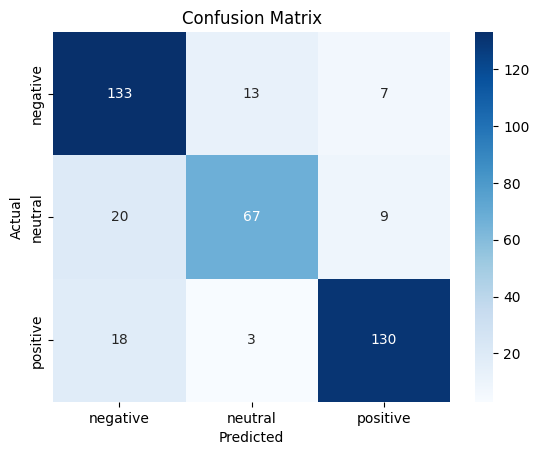

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
labels = label_map.keys()
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Test with Your Own Sentences

In [22]:
def predict_sentiment(text):
    # Remove stop words from input text
    text = stop_words.remove(text)
    # Tokenize input text using BERT tokenizer
    encoding = tokenizer.encode_plus(text, max_length=64, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    inputs = encoding['input_ids'].to(device)
    masks = encoding['attention_mask'].to(device)
    # Pass input through the trained model and return predicted sentiment
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        _, pred_label = torch.max(probs, dim=1)
    return 'positive' if pred_label == 2 else 'neutral' if pred_label == 1 else 'negative'


In [23]:
# Test sentences
test_texts = [
    "Saya sangat senang dengan pelayanan toko ini.",  # Positive sentiment - I am very happy with the service of this store.
    "Produk ini sangat buruk dan tidak berguna.",     # Negative sentiment - This product is very bad and useless.
    "Kualitasnya biasa saja, tidak terlalu bagus.",   # Neutral sentiment - The quality is just okay, not too good.

    "Saya sangat senang dengan pelayanan toko ini. Produk ini sangat buruk dan tidak berguna.",  # Mixed sentiment - I am very happy with the service of this store. This product is very bad and useless.
    "Produk ini sangat bagus, tetapi sayangnya harganya terlalu mahal.",  # Mixed sentiment - This product is very good, but unfortunately the price is too expensive.
    
    "Saya sangat bahagia hari ini",  # Positive sentiment - "I am very happy today"
    "Cuaca sangat buruk",            # Negative sentiment - "The weather is very bad"
    "Saya suka belajar bahasa",      # Positive sentiment - "I like learning languages"
    "Ini adalah hari yang menyedihkan" # Negative sentiment - "This is a sad day"
]

sentiment = [predict_sentiment(text) for text in test_texts]
print(sentiment)

['positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'neutral']
